In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from linearmodels import PanelOLS
#warnings.filterwarnings("ignore")

## Monte Carlo Simulation

This notebook aims to introduce a more rigerous testing framework for the googlebuzz and wikibuzz models

In [12]:
df = pd.read_csv("GoogleBuzzDF.csv")

In [13]:
sort_g = df.sort_values("googlebuzz")
#sort_g = df.sort_values("googlebuzz")
sort_g["googlebuzz"] = np.where(sort_g["win"] == 0, -sort_g["googlebuzz"], sort_g["googlebuzz"])
sort_g["originalgooglebuzz"] = np.where(sort_g["win"] == 0, -sort_g["originalgooglebuzz"], sort_g["originalgooglebuzz"])

In [14]:
df = sort_g

In [89]:
df = df.dropna()
df = df.drop(16916, axis = 0)
df = df.drop(16928, axis = 0)
df = df.drop(20183, axis = 0)
df = df.drop(18620, axis = 0)


In [6]:
df["date"] = [dt.date(int(year), int(month), int(day)) for year,month,day in zip(df["year"],df["month"],df["day"])]
df["date"][0]

datetime.date(2015, 7, 2)

In [19]:
df["googlebuzz"].describe()

count    18840.000000
mean        -0.012514
std        209.537913
min      -3049.041096
25%        -33.370687
50%          0.000000
75%         33.370687
max       3049.041096
Name: googlebuzz, dtype: float64

In [30]:
correlation = df[["wikibuzz","googlebuzz","originalgooglebuzz"]]
correlation.rename(columns={'wikibuzz': 'WikiBuzz', 'googlebuzz': 'AbsGoogleBuzz',"originalgooglebuzz":"LogGoogleBuzz"}, inplace=True)
correlation=(correlation-correlation.mean())/correlation.std()
correlation.corr()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,WikiBuzz,AbsGoogleBuzz,LogGoogleBuzz
WikiBuzz,1.000000,0.298779,0.182866
AbsGoogleBuzz,0.298779,1.000000,0.543190
LogGoogleBuzz,0.182866,0.543190,1.000000


Text(0.5, 1.0, 'Correlation Matrix Between Metrics')

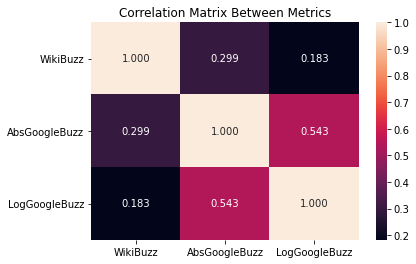

In [31]:
import seaborn as sns
corr = correlation.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,fmt=".3f")
plt.title("Correlation Matrix Between Metrics")


In [61]:
train_data = df[df["year"]>=2017].copy()
test_data = df[df["year"]<2017].copy()

In [91]:
train_data = df.sample(frac = 0.75)
test_data = df.drop(train_data.index)


In [92]:
train_data = train_data.set_index(['match_id'], append=True)
test_data = test_data.set_index(['match_id'], append=True)
test_data = test_data.dropna()
test_data = test_data.sort_values("date")

In [72]:
x= test_data[test_data["year"]==2019]
x[x["month"]==12]

,,Unnamed: 0,player,opponent,year,month,day,rankdiff,rankdist,wikibuzz,inv_bet365,inv_avg,inv_max,encoded_tournament,win,googlebuzz,originalgooglebuzz,date
,match_id,,,,,,,,,,,,,,,,,
20286,20242,20286,Vera Zvonareva,Luksika Kumkhum,2019.0,12.0,30.0,43.0,0.005977,0.306258,0.454545,0.440529,0.416667,99,1,0.000000,0.000000,2019-12-30
20290,20240,20290,Zarina Diyas,Evgeniya Rodina,2019.0,12.0,30.0,18.0,0.002849,-0.043485,0.735294,0.719425,0.694444,99,0,0.000000,0.000000,2019-12-30
20284,20239,20284,Anastasia Pavlyuchenkova,Ana Bogdan,2019.0,12.0,30.0,-34.0,-0.010652,-0.132060,0.735294,0.735294,0.704225,99,1,0.000000,0.000000,2019-12-30
20288,20238,20288,Saisai Zheng,Pauline Parmentier,2019.0,12.0,30.0,-18.0,-0.008459,-0.578737,0.751880,0.735294,0.689655,99,0,0.000000,0.000000,2019-12-30
20297,20250,20297,Lauren Davis,Lara Arruabarrena,2019.0,12.0,31.0,91.0,0.006415,0.516949,0.694444,0.666667,0.636943,3,1,29.833234,3.428593,2019-12-31
20301,20256,20301,Karolina Pliskova,Yulia Putintseva,2019.0,12.0,31.0,-36.0,-0.102273,0.000000,0.862069,0.847458,0.826446,22,1,14.351852,2.731236,2019-12-31
20316,20254,20316,Irina-Camelia Begu,Veronika Kudermetova,2019.0,12.0,31.0,-66.0,-0.007407,0.191379,0.500000,0.495049,0.469484,99,0,0.000000,0.000000,2019-12-31
20302,20257,20302,Monica Puig,Bethanie Mattek-Sands,2019.0,12.0,31.0,-297.0,-0.016011,0.121911,0.735294,0.729927,0.699301,3,1,0.000000,0.000000,2019-12-31
20314,20251,20314,Zhang Shuai,Ons Jabeur,2019.0,12.0,31.0,-20.0,-0.008333,1.396990,0.602410,0.595238,0.571429,99,0,6.115495,1.962275,2019-12-31


# Functions

In [101]:
def probability(const_p,odds_p,rankdist_p,wikibuzz_p,year_p,tournament_p,odds,rankdist,wikibuzz,google_p = 0,googlebuzz = 0): #to be used in conjuncture with a df
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz + google_p*googlebuzz)

def _probability(const_p,odds_p,rankdist_p,wikibuzz_p,google_p,odds,rankdist,wikibuzz,googlebuzz):
    return(const_p + (odds_p)*odds + rankdist_p*rankdist + wikibuzz_p*wikibuzz + google_p*googlebuzz)

def kelly_crit(probability,inv_odds):
               return(max((probability-((1-probability)/((1/inv_odds) - 1)),0)))
    
def profit(kelly,inv_odds,win):
    decimal_odds = 1/inv_odds
    if win == 1: #match won
        return(kelly*decimal_odds - kelly) #profits - inital investment
    elif win == 0: #match lost
        return(-kelly) # - initial investment
    
def corrected_kelly(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",_test_odds="inv_max"):
    _test_data(_odds=_odds,rankdist=rankdist,wikibuzz=wikibuzz,googlebuzz=googlebuzz,test_odds = _test_odds)
    test_data['bankroll_after'] = test_data['profit'] + 1
    test_data['bankroll_after'] = test_data['bankroll_after'].cumprod()
    test_data['bankroll_before'] = test_data.bankroll_after.shift(1)
    test_data['betsize_of_inital_bankroll'] = test_data['kelly'] * test_data['bankroll_before']
    test_data['pnl_of_initial_bankroll'] = test_data['profit'] * test_data['bankroll_before']
    
def correct_kelly_plot_results():
    print('New ROI (%): ' + str((((test_data['pnl_of_initial_bankroll'].sum() + test_data['betsize_of_inital_bankroll'].sum()) / test_data['betsize_of_inital_bankroll'].sum()) - 1)*100))
    test_data["Cum_PnL"] = (test_data["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    test_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5)
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    #ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    
    plt.show()

def corrected_kelly_MC(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",_test_odds="inv_max"):
    _test_data(_odds=_odds,rankdist=rankdist,wikibuzz=wikibuzz,googlebuzz=googlebuzz,test_odds = _test_odds)
    test_data['bankroll_after'] = test_data['profit'] + 1
    test_data['bankroll_after'] = test_data['bankroll_after'].cumprod()
    test_data['bankroll_before'] = test_data.bankroll_after.shift(1)
    test_data['betsize_of_inital_bankroll'] = test_data['kelly'] * test_data['bankroll_before']
    test_data['pnl_of_initial_bankroll'] = test_data['profit'] * test_data['bankroll_before']
    return((((test_data['pnl_of_initial_bankroll'].sum() + test_data['betsize_of_inital_bankroll'].sum()) / test_data['betsize_of_inital_bankroll'].sum()) - 1)*100)

def reload_data():
    train_data = df.sample(frac = 0.75)
    test_data = df.drop(train_data.index)
    train_data = train_data.set_index(['match_id'], append=True)
    test_data = test_data.set_index(['match_id'], append=True)
    test_data = test_data.dropna()
    test_data = test_data.sort_values("date")


In [95]:
def _train_data(odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz"):
    if googlebuzz == False:
        variables = [odds]
    else:
        variables = [odds,googlebuzz]
    if rankdist == True:
        variables.append("rankdist")
    if wikibuzz == True:
        variables.append("wikibuzz")
  #  print(variables)
    exog_vars = train_data[variables]
    exog = sm.add_constant(exog_vars)
    model = PanelOLS(train_data["win"],exog,entity_effects=False)
    results = model.fit()
    x = results.params
  #  print(results)
    return(x)

_train_data(odds="inv_avg",rankdist=False,wikibuzz=True,googlebuzz=False)


const      -0.032116
inv_avg     1.003540
wikibuzz    0.008761
Name: parameter, dtype: float64

In [111]:
def _test_data(_odds="inv_avg",rankdist=True,wikibuzz=True,googlebuzz="googlebuzz",test_odds = "inv_avg"):
    est = _train_data(_odds,rankdist,wikibuzz,googlebuzz)
    
    const_p,odds_p = est["const"],est["inv_avg"]
    if rankdist == True:
        rankdist_p = est["rankdist"]
    else:
        rankdist_p = 0
    if wikibuzz == True:
        wikibuzz_p = est["wikibuzz"]
    else:
        wikibuzz_p = 0
    
    if googlebuzz == False:
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,0,odds,rankdist,wikibuzz,0) for odds,rankdist,wikibuzz in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"])]
    else:
        google_p = est[googlebuzz]
        test_data["avg_prob"] = [_probability(const_p,odds_p,rankdist_p,wikibuzz_p,google_p,odds,rankdist,wikibuzz,googlebuzz_) for odds,rankdist,wikibuzz,googlebuzz_ in zip(test_data["inv_avg"],test_data["rankdist"],test_data["wikibuzz"],test_data[googlebuzz])]
        
    test_data["kelly"] = [kelly_crit(kelly[0],kelly[1]) for kelly in zip(test_data["avg_prob"],test_data[test_odds])]
    test_data["profit"] = [profit(prof[0],prof[1],prof[2]) for prof in zip(test_data["kelly"],test_data[test_odds],test_data["win"])]
    test_data["profit"].describe()
    print()
    print("no of bets: " + str(len(test_data["profit"])-(test_data["profit"]== 0).sum()))
    print("profit: " + str((5160*test_data["profit"].mean())))
    print("Mean overround (%): "+str((test_data.sort_values(by="match_id")[test_odds].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute amount bet: '+str(test_data['kelly'].sum()))
    print('Absolute return: '+str(test_data['profit'].sum()))
    plt.plot(list(test_data["profit"].cumsum()))
#     print(test_data["profit"].describe())
#     print("ROI (%): "+str((((test_data["profit"].sum() + test_data["kelly"].sum())/test_data["kelly"].sum())-1)*100))

['inv_avg', 'googlebuzz', 'rankdist']
                          PanelOLS Estimation Summary                           
Dep. Variable:                    win   R-squared:                        0.1561
Estimator:                   PanelOLS   R-squared (Between):              0.1561
No. Observations:               14127   R-squared (Within):               0.0000
Date:                Wed, Aug 09 2023   R-squared (Overall):              0.1561
Time:                        16:23:27   Log-likelihood                   -9054.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      870.87
Entities:                       14127   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                 F(3,14123)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):          

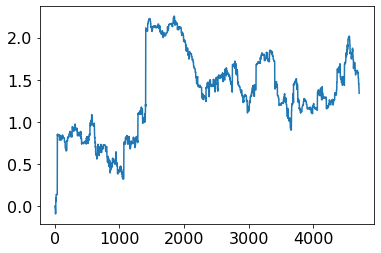

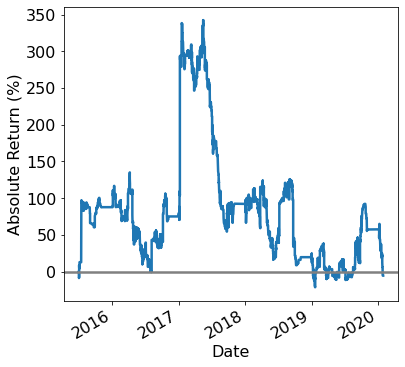

In [93]:

corrected_kelly(_odds="inv_avg",rankdist=True,wikibuzz=False,googlebuzz="googlebuzz",_test_odds = "inv_max")
correct_kelly_plot_results()

In [128]:
pip install alive_progress

  Using cached alive_progress-3.1.4-py3-none-any.whl (75 kB)
  Using cached about_time-4.2.1-py3-none-any.whl (13 kB)
  Using cached grapheme-0.6.0.tar.gz (207 kB)
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210101 sha256=78451a5dfe20a2eab8228e1a647990cc2782fdbe76521a858a24ce2455cd1e76
  Stored in directory: c:\users\griev\appdata\local\pip\cache\wheels\2d\08\6b\126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme
Note: you may need to restart the kernel to use updated packages.


In [129]:
#pip install alive_progress 
from alive_progress import alive_bar

In [141]:
roi = list()

with alive_bar(1000,force_tty = True) as bar:
    for i in range(1000):
        train_data = df.sample(frac = 0.75)
        test_data = df.drop(train_data.index)
        train_data = train_data.set_index(['match_id'], append=True)
        test_data = test_data.set_index(['match_id'], append=True)
        test_data = test_data.dropna()
        test_data = test_data.sort_values("date")
        roi.append(corrected_kelly_MC(_odds="inv_avg",rankdist=True,wikibuzz=False,googlebuzz="originalgooglebuzz",_test_odds = "inv_max"))
        bar()

    

|████████████████████████████████████████| 1000/1000 [100%] in 5:35.4 (2.98/s)  in 19s (~4:30, 3.5/s ▆█▆ 157/1000 [16%] in 51s (~4:34, 3.1▇▅▃ 158/1000 [16%] in 52s (~4:34, 3.1 ▆▄▂ 167/1000 [17%] in 57s (~4:40, 3.0in 57s (~4:40, 3.0 187/1000 [19%] in 1:03 (~4:35, 3. ▁▃▅ 200/1000 [20%] in 1:08 (~4:30, 3. ▆█▆ 202/1000 [20%] in 1:09 (~4:30, 3.in 1:13 (~4:27, 2. 219/1000 [22%] in 1:15 (~4:27, 2.(~4:27, 2. 237/1000 [24%] in 1:23 (~4:26, 2. 239/1000 [24%] in 1:24 (~4:26, 2.▅▇▇ 256/1000 [26%] in 1:30 (~4:20, 2.303/1000 [30%] in 1:45 (~4:02, 2. ▇▅▃ 308/1000 [31%] in 1:47 (~4:00, 2.▄▂▂ 348/1000 [35%] in 2:00 (~3:45, 2. ▃▁▃ 361/1000 [36%] in 2:04 (~3:40, 2. ▃▁▃ 366/1000 [37%] in 2:07 (~3:39, 2.▂▂▄ 394/1000 [39%] in 2:17 (~3:31, 2. ▁▃▅ 584/1000 [58%] in 3:16 (~2:20, 3. ▇▇▅ 587/1000 [59%] in 3:17 (~2:19, 3.▁▃▅ 616/1000 [62%] in 3:27 (~2:09, 3.▄▂▂ 624/1000 [62%] in 3:31 (~2:07, 3.626/1000 [63%] in 3:32 (~2:06, 3. 649/1000 [65%] in 3:41 (~1:59, 2. ▃▁▃ 650/1000 [65%] in 3:41 (~1:59, 2.in 3:47 (~1:55, 

,0
count,1000.000000
mean,0.279791
std,3.095225
min,-12.626029
25%,-1.429409
50%,0.234721
75%,1.997425
max,13.200042


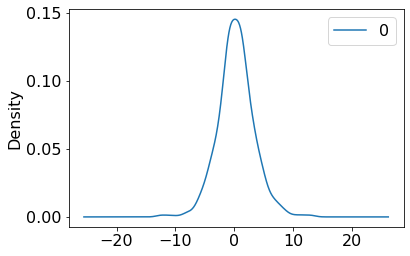

In [142]:

x = pd.DataFrame(roi)
x.describe()
x.plot(kind = "density")
x.describe()